In [73]:
using ReactiveMP, GraphPPL, Rocket, Distributions
using Random
using  BenchmarkTools

In [74]:
@model function filtering(Q::ConstVariable, R::ConstVariable)
    A = datavar(Vector{Float64})
    B = constvar([ .0 .0 .0 .0; .0 .0 .0 .0; .0 .0 1. .0; .0 .0 .0 1. ]) 
    prior_m1=[ 0.0, 0.0, 1/8π, 0.01 ]
    prior_m2=[ 0.0, 0.0, -1/8π, 0.01 ]
    prior_w1=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1/16π .0; 0.0 0.0 0.0 0.05]
    prior_w2=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1/16π .0; 0.0 0.0 0.0 0.05]

    nmixtures=2

    m = randomvar(nmixtures)
    w = randomvar(nmixtures)

    mean_mean_cov       = [ 1e-6 0.0 0.0 0.0; 0.0 1e-6 0.0 0.0; 0.0 0.0 1e-1 0.0; 0.0 0.0 0.0 1e-1 ]

    m[1] ~ MvNormalMeanCovariance(prior_m1, mean_mean_cov)
    m[2] ~ MvNormalMeanCovariance(prior_m2, mean_mean_cov)
    w[1] ~ Wishart(5, prior_w1)
    w[2] ~ Wishart(5, prior_w2)

    means = tuple(m...)
    precs = tuple(w...)
    # control ~ NormalMixture(intent, means, precs)

    x_k_mean = datavar(Vector{Float64})
    x_k_cov  = datavar(Matrix{Float64})
    # intent = randomvar()

    # control_mean = datavar(Vector{Float64})
    # control_covariance = datavar(Matrix{Float64})
    
    #control depends on intent, and intent is a Bernoulli Distributions.
    #control is GMM Distributions

    intent ~ Categorical([0.5,0.5]) where { q = MeanField() }
    # y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2))
    println(intent)
    println("nimama")
    # println((m1, m2))
    control = randomvar()
    control ~ NormalMixture(intent, means, precs) where { q = MeanField() }

    # control ~ MvNormalMeanCovariance(control_mean,  control_covariance)
    x_k ~ MvNormalMeanCovariance(x_k_mean, x_k_cov)
    
    tmp1 ~ (A + x_k) 
    tmp2 ~ (B * control)

    x_k_p_one ~ MvNormalMeanCovariance(tmp1 + tmp2, Q)
    
    y_k = datavar(Vector{Float64})
    
    y_k ~ MvNormalMeanCovariance(x_k_p_one, R)
    
    return x_k_mean, x_k_cov, x_k_p_one, y_k, A, control, intent, m, w
end

filtering (generic function with 1 method)

In [75]:
function getAFromState(x,δt)
    A=zeros(4)
    A[1]=x[4]*cos(x[3])*δt
    A[2]=x[4]*sin(x[3])*δt
    return A
end

getAFromState (generic function with 1 method)

In [76]:
function generateNewObservation(ii, δt, observation, actual_control)
    
    # 1.0 simulate true action
    
    # 2.0 update your observation

    q=diageye(4)*0.000001

    if div(ii, 100) % 2 == 0
        c_m=zeros(4)
        c_m[3]=-1/8π
        c_m[4]=0.02
        actual_control=c_m
    end

    # println(actual_control)

    x=observation
    μ=actual_control
    x_0=rand(rng,MvNormal(x+[x[4]*cos(x[3])*δt,x[4]*sin(x[3])*δt,0,0]+μ*δt,q))
    # x_0=x+[x[4]*cos(x[3])*δt,x[4]*sin(x[3])*δt,0,0]+μ*δt

    
    # return [x,y,f,v]
    return x_0
end

generateNewObservation (generic function with 1 method)

In [77]:
function inference(δt, max_data_points, max_vmp_iterations)
    
    data_stream = ReplaySubject(Vector{Float64}, 1)

    saved_controls = []
    saved_position = []
    saved_observations = []
    saved_intent   = []
    ii = 0

    # y_current = zeros(4)
    # y_current = [0.0,0.0,0,1.0]
    
    # TODO: Depend on δt
    Q = diageye(4)
    R = diageye(4)
    
    model, (x_k_mean, x_k_cov, x_k_p_one, y_k, A, control, intent, m, w) = filtering(Q, R)
    
    # update!(x_k_mean, zeros(4))
    # update!(x_k_cov,  diageye(4))
    
    # update!(A, getJacobianFromState(y_current, δt))
    # update!(A, getAFromState(y_current, δt))
    # update!(y_k, y_current)

    setmarginal!(m[1], MvNormalMeanCovariance(ones(4), diageye(4)))
    setmarginal!(m[2], MvNormalMeanCovariance(zeros(4), diageye(4)))

    setmarginal!(w[1], Wishart(5, diageye(4)))
    setmarginal!(w[2], Wishart(5, diageye(4)))

    setmarginal!(intent, vague(Categorical, 2))
    setmarginal!(control, vague(MvNormalMeanCovariance, 4))
    setmarginal!(x_k_p_one, vague(MvNormalMeanCovariance, 4))

    

    stream = combineLatest(
        (
        getmarginal(x_k_p_one, IncludeAll()), 
        getmarginal(control, IncludeAll()), 
        getmarginal(intent, IncludeAll()), 
        data_stream
        ), PushNew()
    )

    # push!(saved_controls, control_posterior)   
    #     push!(saved_position, x_k_p_one_posterior)
    #     push!(saved_intent, intent_posterior)
    # push!(saved_observations, y_current)

    fe_actor = ScoreActor(Float64)

    fe_subscription = subscribe!(score(Float64, BetheFreeEnergy(), model), fe_actor)

    finish = Condition()
    
    subscription = subscribe!(stream |> async() |> take(max_data_points) |> tap_on_complete(() -> notify(finish)), (d) -> begin

        x_k_p_one_posterior = d[1]
        control_posterior   = d[2] 
        intent_posterior    = d[3]
        data_point          = d[4]

        push!(saved_observations, data_point)

        μ, Σ = mean_cov(x_k_p_one_posterior)
        pA = getAFromState(μ, δt)
        
        for k in 1:max_vmp_iterations
            update!(x_k_mean, μ)
                
            # TODO: check if forgetting helps or not
            # update!(x_k_cov, 2 * Σ)
            update!(x_k_cov, Σ)
                
            # Update A here
            update!(A, pA)

            update!(y_k, data_point)
            # update!(intent, mean(intent_posterior))
        end

        release!(fe_actor)

        index = length(saved_controls)
        ii = ii + 1

        # Save our result

        push!(saved_controls, Rocket.getrecent(getmarginal(control, IncludeAll())))   
        push!(saved_position, Rocket.getrecent(getmarginal(x_k_p_one, IncludeAll())))  
        push!(saved_intent, Rocket.getrecent(getmarginal(intent, IncludeAll())))  
            
        # update y_current somehow

        #true action
        
        c_m=zeros(4)
        c_m[3]=1/16π
        c_m[4]=0.01
        
        y_next = generateNewObservation(ii, δt, data_point, c_m)  
            
        next!(data_stream, y_next)

        # update!(control_mean, mean(control_posterior))
        # update!(control_covariance, [ 1e-12 .0 .0 .0; .0 1e-12 .0 .0; .0 .0 1. .0; .0 .0 .0 1. ])
        # update!(control_covariance, 1.05*cov(control_posterior))
    end)

    next!(data_stream, zeros(4)) # Initial state
    
    wait(finish)

    # unsubscribe!(subscription)
    
    return saved_controls, saved_observations, saved_position, saved_intent, getvalues(fe_actor)
end

inference (generic function with 1 method)

In [78]:
δt = 1

1

In [79]:
rng= MersenneTwister(1234)
controls, obs, pos,intents, fe = inference(δt, 500, 25);

RandomVariable(intent)
nimama


In [81]:
obs

500-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0]
 [0.0008673472019512456, -0.0009017438158568171, -0.04028321452647807, 0.019097085706134758]
 [0.02081334153921429, 0.0005410497263193248, -0.07953913701728237, 0.038825350310100135]
 [0.06001827728943999, -0.0030608136146361735, -0.11988837412843698, 0.05880605852841029]
 [0.11853028993190337, -0.008241316610036086, -0.16050487333322774, 0.07891615465473246]
 [0.1961809375756478, -0.020483714966449493, -0.20022149275305032, 0.09741272519738142]
 [0.29321177316001384, -0.04125451690920912, -0.23890473068691825, 0.11630599528385585]
 [0.40300305574340406, -0.06885102020643016, -0.2785424908422599, 0.13707527354439042]
 [0.5344849129930952, -0.1071432052586772, -0.3196108988254521, 0.15807259070004792]
 [0.6848547736670135, -0.1568456147821264, -0.3592576603400411, 0.17859386335651597]
 ⋮
 [43.593213642952705, 672.8166752163411, -7.599576935840044, 7.819656813410473]
 [45.560070850761385, 665.2473279326124, -7.638512287987684, 7.841612165921

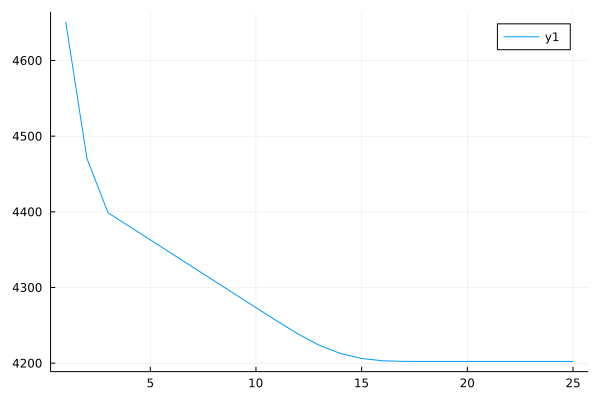

In [82]:
using Plots
plot(fe)

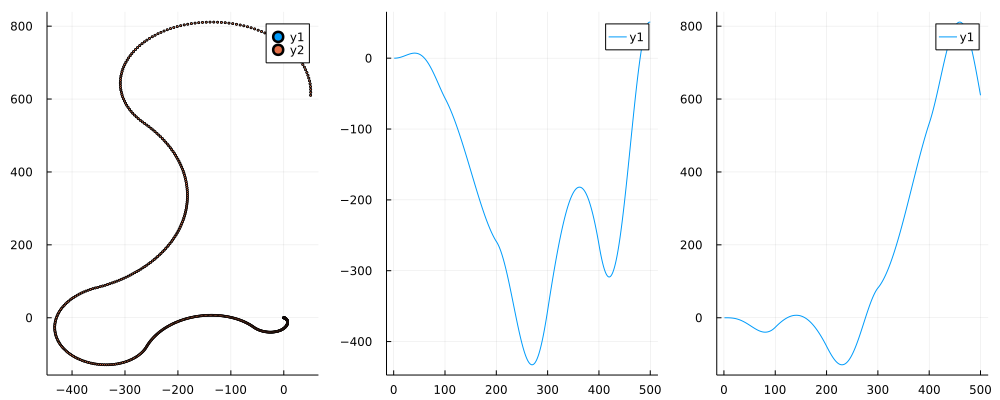

In [85]:
p1 = scatter(map(o -> o[1], obs), map(o -> o[2], obs),  ms = 2)
p1 = scatter!(map(o -> o[1], mean.(pos)), map(o -> o[2], mean.(pos)),  ms = 2)

p2 = plot(map(o -> o[1], obs))
p3 = plot(map(o -> o[2], obs))

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1000, 400))

In [86]:
mean.(controls)

500-element Vector{Vector{Float64}}:
 [8.773671430058545e-31, 8.773671429237144e-31, 1.891462676447973e-8, 0.009999999999918801]
 [7.04862871998778e-61, 7.04862871998778e-61, -0.030543206776515876, 0.015111678664424578]
 [5.463959742104337e-96, 5.463959742104337e-96, -0.0324340958234093, 0.01634616112133385]
 [3.436370762931838e-131, 3.436370762931838e-131, -0.03342449032890462, 0.01667953661251251]
 [2.08934760403358e-166, 2.08934760403358e-166, -0.03370884573731106, 0.016803749775754787]
 [1.0804762214488613e-201, 1.0804762214488613e-201, -0.033045180064996016, 0.01589573994357474]
 [6.548853148134501e-237, 6.548853148134501e-237, -0.03220269897607561, 0.015987875516976346]
 [4.621521929911654e-272, 4.621521929911654e-272, -0.03286276979846179, 0.01707894445927402]
 [2.8735384540975524e-307, 2.8735384540975524e-307, -0.034008133109043055, 0.017372918709942]
 [0.0, 0.0, -0.03301615943423813, 0.01714347011599075]
 ⋮
 [0.0, 0.0, -0.03346148972211742, 0.01617468785199121]
 [0.0, 0.0, -0.

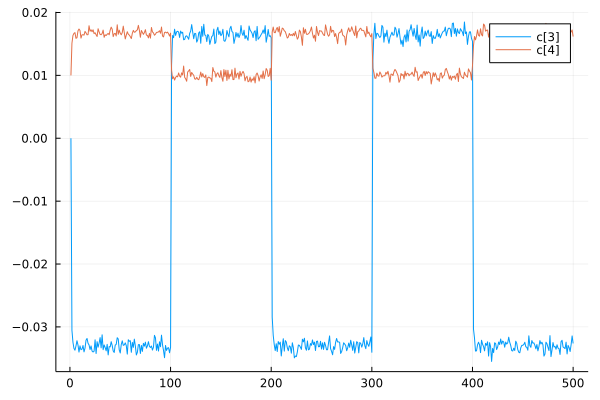

In [87]:
plot(map(c -> c[3] / δt, mean.(controls)), label = "c[3]")
# plot(map(c -> c[3] / δt, mean.(controls)), ribbon = map(c -> c[3] / δt, var.(controls)), label = "c[3]")
plot!(map(c -> c[4] / δt, mean.(controls)), label = "c[4]")
# plot!(map(c -> c[3] / δt, var.(controls)), label = "c[3]")
# plot!(map(c -> c[4] / δt, var.(controls)), label = "c[4]v")

In [88]:
1/16π

0.019894367886486918

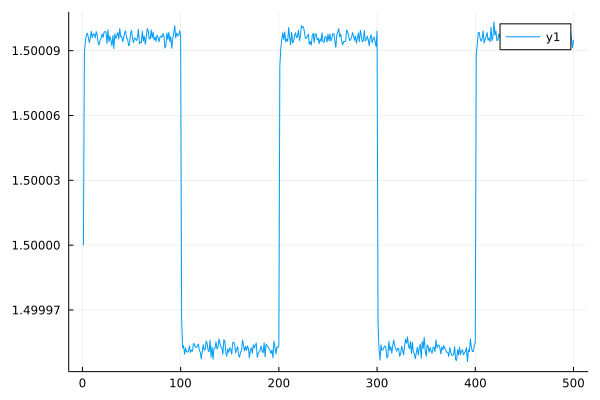

In [89]:
plot(mean.(intents))
# println(var.(intents))

In [90]:
cov.(controls)[2]

4×4 Matrix{Float64}:
  0.2           1.91749e-49  -2.55125e-62   2.33775e-58
  1.91749e-49   0.2          -2.55125e-62   2.33775e-58
 -2.55125e-62  -2.55125e-62   2.27155      -1.5072e-6
  2.33775e-58   2.33775e-58  -1.5072e-6     1.67602